In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<li>1 https://github.com/tuna-date/Face-Recognition-with-InsightFace</li>

<li>2 https://github.com/tuna-date/Face-Recognition-with-InsightFace/blob/master/src/softmax.py</li>

In [ ]:
# https://github.com/tuna-date/Face-Recognition-with-InsightFace/blob/master/src/softmax.py

In [3]:
# from keras.layers import Dense, Dropout
# from keras.models import Sequential
# from keras.optimizers import Adam
# import keras

In [4]:
# class SoftMax():
#     def __init__(self,input_shape, num_classes):
#         self.input_shape = input_shape
#         self.num_class   = num_classes
#     def build(self):
#         model = Sequential()
#         model.add(Dense(1024,activate = 'relu',
#                         input_shape = self.input_shape))
#         model.add(Dropout(0.5))
#         model.add(Dense(1024,activate = 'relu'))
#         model.add(Dropout(0.5))
#         model.add(Dense(self.num_classes, activation = "softmax"))
#         # Why not AdamW?
#         optimizer = Adam(lr=0.001,
#                          beta_1 = 0.9,
#                          beta_2 = 0.999,
#                          epsilon = None,
#                          decay = 0.0,
#                          amsgrad = False)
#         model.compile(loss=keras.losses.categorical_crossentropy,
#                       optimizer = optimizer,
#                       metrics = ['accuracy'])
#         return model


<hr>

<a href="https://github.com/tuna-date/Face-Recognition-with-InsightFace/blob/master/src/train_softmax.py"><h3>https://github.com/tuna-date/Face-Recognition-with-InsightFace/blob/master/src/train_softmax.py</h3></a>

In [55]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import argparse
import pickle

In [56]:
embeddings         = "/content/drive/MyDrive/coconut/embeddings_small_datasets.pickle"
model              = "outputs/my_model.5"
label_encoder_path = "outputs/le.pickle"

In [57]:
with open(embeddings,"rb") as f:
    data = pickle.load(f)
data

{'embeddings': [array([-3.14872354e-01, -4.27063465e-01,  5.22802234e-01,  5.14245212e-01,
         -4.13114160e-01, -4.71814930e-01, -4.64256942e-01, -2.52645075e-01,
         -4.69752908e-01,  5.04767418e-01,  2.10747927e-01,  5.33535838e-01,
         -6.59637570e-01,  9.86711010e-02, -7.71820545e-01,  3.69555384e-01,
          2.80338734e-01, -3.36396486e-01, -9.90020558e-02, -4.32185084e-03,
         -3.20111364e-01,  1.20543456e+00,  6.23659194e-01, -2.82927901e-01,
         -4.05641556e-01,  5.57939947e-01, -3.28308403e-01, -4.65822697e-01,
         -4.60866749e-01, -1.76500976e-02,  5.54599352e-02, -1.40793115e-01,
          7.50216246e-01,  6.39490366e-01, -9.70703661e-01, -7.56544471e-02,
          2.37489015e-01,  5.63965678e-01, -1.48624510e-01,  3.97396922e-01,
         -1.59988940e-01,  8.87625992e-01,  1.09974131e-01, -3.69868308e-01,
         -4.19710129e-02, -1.88776225e-01, -4.66654181e-01, -1.11984611e-02,
         -7.75128901e-01, -2.97193468e-01,  2.95513332e-01, -6

In [59]:
# Encode the labels
le = LabelEncoder()
labels = le.fit_transform(data["names"])     # convert name -> number 0,1,2,3,4,....
num_classes = len(np.unique(labels))         # How many people
labels = labels.reshape(-1,1)                # เปลี่ยน มิติ ของข้อมูล

one_hot_encoder = OneHotEncoder(sparse = False)  # ทำให้เป็น One hot
labels = one_hot_encoder.fit_transform(labels)   # ทำให้เป็น One hot
labels                                           # ทำให้เป็น One hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [60]:
embeddings = np.array(data["embeddings"])          # convert to numpy metrix with value 0-1
embeddings

array([[-0.31487235, -0.42706347,  0.52280223, ...,  0.42501712,
         0.22862259, -0.07920823],
       [-1.2585095 , -1.1850462 ,  0.41342998, ...,  0.17650986,
         0.2679866 , -0.22779262],
       [ 0.9985887 , -0.41943833,  1.4795845 , ...,  0.49442238,
        -1.0549494 , -0.35636312],
       [-1.3575168 , -0.9239486 ,  0.95127076, ...,  0.9454914 ,
         0.26705614,  0.53970635],
       [ 1.0726166 ,  0.06303011, -0.8219152 , ..., -1.5109133 ,
         1.3888775 , -0.7094474 ],
       [ 0.13724051, -1.3412741 ,  0.25182447, ..., -0.56681275,
        -0.26390472, -0.3075515 ]], dtype=float32)

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
import keras

class SoftMax():
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    # def build(self):
    #     model = Sequential()
    #     # Use Input layer for the input shape
    #     model.add(Input(shape=self.input_shape))
    #     model.add(Dense(1024, activation='relu'))  # Corrected "activation"
    #     model.add(Dropout(0.5))
    #     model.add(Dense(1024, activation='relu'))  # Corrected "activation"
    #     model.add(Dropout(0.5))
    #     model.add(Dense(self.num_classes, activation='softmax'))  # Corrected "activation"

    #     # Adam optimizer with given parameters
    #     optimizer = Adam(learning_rate=0.001,
    #                      beta_1=0.9,
    #                      beta_2=0.999,
    #                      epsilon=None,
    #                      decay=0.0,
    #                      amsgrad=False)

    #     # Compile the model
    #     model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    def build(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.num_classes, activation='softmax'))

        optimizer = Adam(learning_rate=0.001)
        model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])

        return model  # Ensure the model is returned


        return model


In [79]:
# Check shapes of embeddings and labels
print("Embeddings shape:", embeddings.shape)  # Should print (6, 512)
print("Labels shape:", labels.shape)          # Should print (6, 3)

BATCH_SIZE = 32
EPOCHS = 20
input_shape = embeddings.shape[1]    # Data shape is (6,512) There are 6 image with 512 Embedding vector
print(input_shape)

Embeddings shape: (6, 512)
Labels shape: (6, 3)
512


In [80]:
softmax = SoftMax(input_shape=(input_shape,), num_classes=num_classes)
model = softmax.build()
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,577,987 (6.02 MB)

 Trainable params: 1,577,987 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Fit the model
model.fit(embeddings, labels, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 2.3706
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6667 - loss: 0.9396
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 0.1409
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0179
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 0.0104
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 2.5371e-05
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.1285e-05
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 2.8005e-04
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 1.0000 - loss: 2.6226e-06
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 9.9341e-08
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1

In [82]:
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pickle

# Create KFold with 5 splits
cv = KFold(n_splits=5, random_state=42, shuffle=True)
history = {'acc': [], 'val_acc': [], 'loss': [], 'val_loss': []}

# Train model with KFold
for train_idx, valid_idx in cv.split(embeddings):
    X_train, X_val = embeddings[train_idx], embeddings[valid_idx]
    y_train, y_val = labels[train_idx], labels[valid_idx]

    # Reinitialize the model for each fold
    softmax = SoftMax(input_shape=(input_shape,), num_classes=num_classes)
    model = softmax.build()

    # Train the model
    his = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(X_val, y_val))

    # Append the history for accuracy and loss
    history['acc'] += his.history['accuracy']  # Updated to 'accuracy' key
    history['val_acc'] += his.history['val_accuracy']  # Updated to 'val_accuracy'
    history['loss'] += his.history['loss']
    history['val_loss'] += his.history['val_loss']

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2500 - loss: 0.9998 - val_accuracy: 0.0000e+00 - val_loss: 1.4400
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 1.0000 - loss: 0.0491 - val_accuracy: 0.0000e+00 - val_loss: 1.8826
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 1.0000 - loss: 0.0490 - val_accuracy: 0.0000e+00 - val_loss: 2.2930
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 5.6937e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.6625
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 1.0000 - loss: 3.4629e-05 - val_accuracy: 0.0000e+00 - val_loss: 2.9949
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 1.0000 - loss: 6.7055e-06 - val_accuracy: 0.0000e+00 - val_loss: 3.2968
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 1.9669e-06 - val_accuracy: 0.0000e+00 - val_loss: 3.5710
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 5

In [85]:
model

<Sequential name=sequential_16, built=True>

In [86]:
# Correctly save the model to a file
model.save("outputs/my_model.h5")  # Save the model with .h5 extension

# Save the label encoder
with open(label_encoder_path, "wb") as f:
    pickle.dump(le, f)


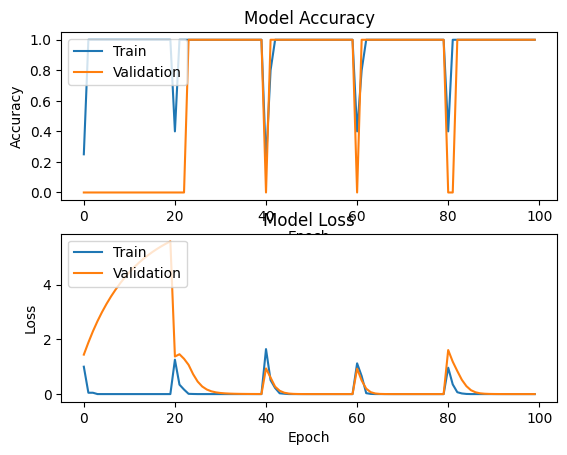

In [87]:
# Plot training history for accuracy and loss
plt.figure(1)

# Summary history for accuracy
plt.subplot(211)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summary history for loss
plt.subplot(212)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the accuracy and loss plot
plt.savefig('outputs/accuracy_loss.png')
plt.show()